# Data preparation 

Let's first only classify 30 dog breed from Standford dataset. 
Which are the one with the most images provided (number of images superior to the third inter-quartile)

https://www.youtube.com/watch?v=7Mv91hcxCCI&t=137s

In [1]:
import matplotlib.pyplot as plt

In [80]:
%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import cv2 

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split

from common_params import data_dir, img_dir
from common_plots import display_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(tf.__version__)

2.11.0


In [4]:
data = pd.read_csv("selected_breed.csv")


In [5]:
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,dog_breed,folder_name,image_count
0,Maltese_dog,n02085936-Maltese_dog,252.0
1,Afghan_hound,n02088094-Afghan_hound,239.0
2,Scottish_deerhound,n02092002-Scottish_deerhound,232.0
3,Pomeranian,n02112018-Pomeranian,219.0
4,Samoyed,n02111889-Samoyed,218.0


### Load images 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

In [119]:
IMG_SIZE = 224
batch_size = 32

# Add : only take 30 classes

In [41]:


imgsub_dir = os.path.join(data_dir,"images_subset")
if not os.path.isdir(imgsub_dir) : 
    os.mkdir(os.path.join(data_dir,"images_subset"))


In [42]:
# importing shutil module 
import shutil 

for folder in data["folder_name"].tolist() : 
    location = os.path.join(img_dir,folder)
    destination = os.path.join(imgsub_dir,folder)
    if not os.path.isdir(destination) : 
        dest = shutil.copytree(location,destination)
        print(dest)

C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog
C:/dev/image_classification/data/images_subset\n02088094-Afghan_hound
C:/dev/image_classification/data/images_subset\n02092002-Scottish_deerhound
C:/dev/image_classification/data/images_subset\n02112018-Pomeranian
C:/dev/image_classification/data/images_subset\n02111889-Samoyed
C:/dev/image_classification/data/images_subset\n02090721-Irish_wolfhound
C:/dev/image_classification/data/images_subset\n02107683-Bernese_mountain_dog
C:/dev/image_classification/data/images_subset\n02086240-Shih-Tzu
C:/dev/image_classification/data/images_subset\n02111500-Great_Pyrenees
C:/dev/image_classification/data/images_subset\n02111129-Leonberg
C:/dev/image_classification/data/images_subset\n02110806-basenji
C:/dev/image_classification/data/images_subset\n02097474-Tibetan_terrier
C:/dev/image_classification/data/images_subset\n02096051-Airedale
C:/dev/image_classification/data/images_subset\n02095889-Sealyham_terrier
C:/dev/image_classi

In [118]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgsub_dir,
    batch_size=batch_size,
    seed=59,
    labels= "inferred",
    subset="training",
    validation_split=0.2,
    image_size=(IMG_SIZE, IMG_SIZE))


SyntaxError: keyword argument repeated (1703642772.py, line 8)

In [111]:
class_names = train_ds.class_names
class_names

['n02085936-Maltese_dog',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02088094-Afghan_hound',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02090721-Irish_wolfhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02095570-Lakeland_terrier',
 'n02095889-Sealyham_terrier',
 'n02096051-Airedale',
 'n02096177-cairn',
 'n02096294-Australian_terrier',
 'n02097474-Tibetan_terrier',
 'n02107683-Bernese_mountain_dog',
 'n02108000-EntleBucher',
 'n02110185-Siberian_husky',
 'n02110806-basenji',
 'n02110958-pug',
 'n02111129-Leonberg',
 'n02111277-Newfoundland',
 'n02111500-Great_Pyrenees',
 'n02111889-Samoyed',
 'n02112018-Pomeranian',
 'n02112137-chow']

In [77]:
num_classes = len(class_names)
num_classes

30

In [109]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgsub_dir,
    batch_size=batch_size,
    seed=59,
    validation_split=0.2,
    labels= "inferred",
    subset="validation",
    batch_size=batch_size,
    image_size=(IMG_SIZE, IMG_SIZE))


Found 6164 files belonging to 30 classes.
Using 1232 files for validation.


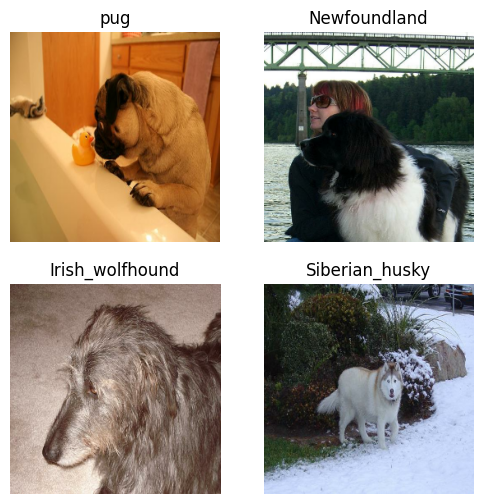

In [52]:
plt.figure(figsize=(6, 6))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].split('-')[1])
        plt.axis("off")

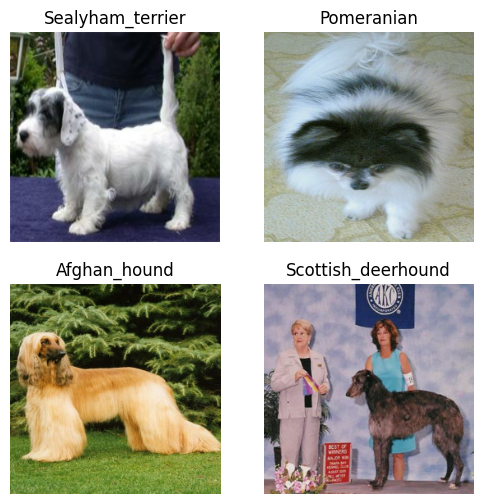

In [53]:
plt.figure(figsize=(6, 6))
class_names = validation_ds.class_names
for images, labels in validation_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].split('-')[1])
        plt.axis("off")

# Data augmentation 

In [54]:
data_augmentation = tf.keras.Sequential(
    [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1)
            
    ]
)

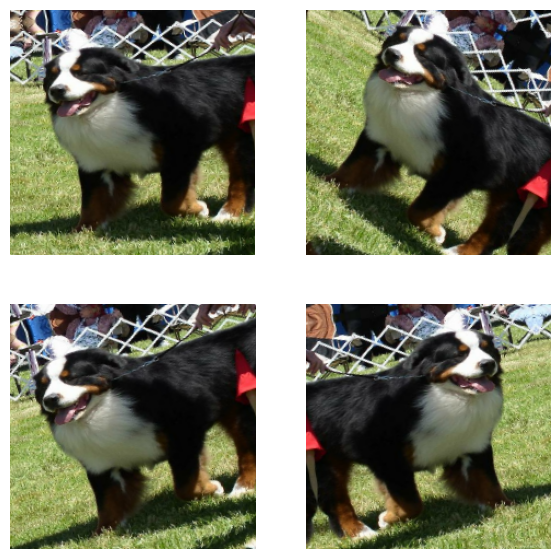

In [112]:

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [113]:
augmented_train_dataset = train_ds.map(
    lambda x, y : (data_augmentation(x,training=True), y )
)

In [72]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU available : {len(physical_devices)}")

Number of GPU available : 0


# Transfer Learning with RestNet-152
tf.keras.applications.resnet.ResNet152 to load the ResNet-152 architecture with pre-trained ImageNet weights:

In [84]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
# Create an Input layer with the desired input shape
input_shape = (224, 224, 3)  # Example input shape
input_tensor = Input(shape=input_shape)

# Load ResNet-152 model with pre-trained ImageNet weights
resnet152_model = ResNet152(
    include_top=True,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=input_shape,
    pooling=None,  # You can specify 'avg' or 'max' pooling here if needed
    classes=1000
)
resnet152_model.trainable = False


In [115]:

# Set the pooling layer
x = Flatten()(resnet152_model.output)
x = Dense(512, activation='relu')(x)
# Set the final layer with sigmoid activation function
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the new model object
model = tf.keras.Model(inputs=resnet152_model.input , outputs=output)
# Compile it
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Model training 

In [100]:
from datetime import datetime

In [ ]:
# Define hyperparameters and input data
learning_rate = 0.01
num_epochs = 50

input_shape = (224, 224, 3)

# Define names for tensorboard logging and mlflow
experiment_name = "dog-breed-classifier-ResNet152"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

In [116]:
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [117]:
# Train the model and log metrics and the model itself to MLflow
history = model.fit(
    augmented_train_dataset ,
    epochs=num_epochs,
    validation_data=validation_ds,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/50


ValueError: in user code:

    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\dev\image_classification\IMG2\lib\site-packages\keras\backend.py", line 5681, in binary_crossentropy
        labels=target, logits=output

    ValueError: `logits` and `labels` must have the same shape, received ((None, 30) vs (None, 1)).


In [102]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
test_img = os.path.join(img_dir , "n02085620-Chihuahua\\n02085620_7.jpg")

: 

In [ ]:
directory = os.path.join(data_dir , "generated/")
img_list = [ directory + file for file in os.listdir(directory) ] 
len(img_list)

: 

In [ ]:
display_images(img_list,2,4)

: 

# Convolutional neural network 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3 ))) # kernel = 3*3
model.add(MaxPooling2D((2, 2),strides=(2,2),padding="same"))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

: 

In [ ]:
model.summary()

: 